## I/O System Demo for  GeoidIO and SSHIO

### Import GeoidIO from gocean

In [81]:
import numpy as np
from matplotlib import pyplot as plt

from gocean.io.geoid import GeoidIO

### Set the data directory for GeoidIO and read the .gdf file

In [82]:
# Set the data directory to GeoidIO
geoid = GeoidIO(data_dir='../../data')

# READ required file
geoid.read('geoid.gdf')

### Let's view the data and header for the geoid

In [83]:
# Required header elements
print('header: \n')
for key in geoid.header.keys():
    print(key, ': ', geoid.header[key])

header: 

lat_max :  22.78
lat_min :  5.18
long_min :  77.77
long_max :  98.67
latitude_parallels :  177
longitude_parallels :  210


In [84]:
# Geoid Data
print('Data: \n', geoid.data)

Data: 
         long    lat      geoid
0      77.77  22.78 -58.897233
1      77.87  22.78 -58.982584
2      77.97  22.78 -59.060798
3      78.07  22.78 -59.127344
4      78.17  22.78 -59.178009
...      ...    ...        ...
37165  98.27   5.18 -20.974614
37166  98.37   5.18 -20.494548
37167  98.47   5.18 -19.996221
37168  98.57   5.18 -19.483223
37169  98.67   5.18 -18.961050

[37170 rows x 3 columns]


### Create a Geoid grid and visualize

In [85]:
# Create geoid grid
geoid.create_geoid_grid()

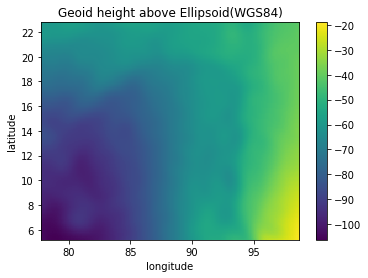

In [86]:
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geoid height above Ellipsoid(WGS84)')

plt.colorbar()
plt.savefig('geoid.png')
plt.show()

### Import SSHIO from gocean

In [87]:
from gocean.io.altimetry import SSHIO

### Set the data directory for jason and saral data

In [88]:
jason = SSHIO('../../data/altimetry')

### Read the SSH data and fill the similar grid as geoid

In [89]:
jason.read(geoid.grid)

### Visualize SSH from Jason and SARAL

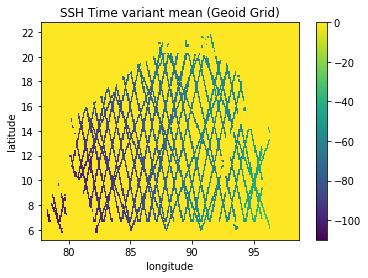

In [90]:
plt.imshow(jason.grid[:, :, 1], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH Time variant mean (Geoid Grid)')

plt.colorbar()

plt.savefig('ssh-tvm.png')
plt.show()

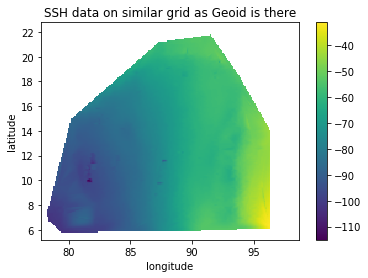

In [91]:
# plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
#                                         geoid.header['long_max'],
#                                         geoid.header['lat_min'],
#                                         geoid.header['lat_max']])
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data on similar grid as Geoid is there')

plt.colorbar()

plt.savefig('ssh.png')
plt.show()

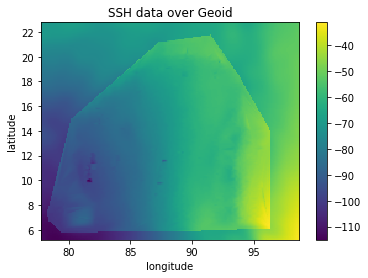

In [92]:
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data over Geoid')

plt.colorbar()

plt.savefig('ssh-geoid.png')
plt.show()


### Import mdt from gocean.currents module

In [93]:
from gocean.currents.mdt import mdt

In [94]:
mdt_grid = mdt(geoid.grid[:, :, 2], jason.grid_filled)

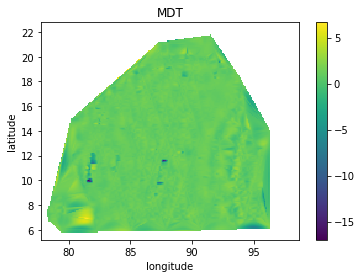

In [95]:
plt.imshow(mdt_grid, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT')

plt.colorbar()

plt.savefig('mdt.png')
plt.show()

### Import filtering utility

In [96]:
from gocean.preprocessing.filters import gaussian

In [97]:
mdt_final = mdt_grid
mdt_final[jason.mask] = 0

In [98]:
mdt_filtered = gaussian(mdt_final, jason.mask, sigma=2)

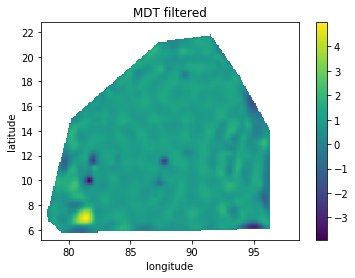

In [99]:
plt.imshow(mdt_filtered, extent=[geoid.header['long_min'],
                             geoid.header['long_max'],
                             geoid.header['lat_min'],
                             geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('MDT filtered')

plt.colorbar()

plt.savefig('mdt-filtered.png')
plt.show()


In [100]:
from gocean.currents.current import decompose

In [106]:
u, v = decompose(mdt_final, geoid.grid[:, :, :2])

(177, 210)


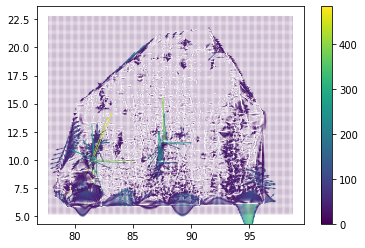

In [107]:
u[jason.mask] = 0
v[jason.mask] = 0

# plt.imshow(u)
# plt.imshow(v)
plt.quiver(geoid.grid[:, :, 1], geoid.grid[:, :, 0], v, u, np.sqrt(u**2+v**2))
plt.colorbar()
plt.show()

In [113]:
row_block = 50
col_block = 50
for row in np.arange(0, 177, row_block):
    for col in np.arange(0, 210, col_block):
        row_begin = row
        row_end = row_begin+row_block
        if row_end > 177:
            row_end = 177

        col_begin = col
        col_end = col_begin+col_block
        if col_end > 177:
            col_end = 177
        plt.quiver(geoid.grid[row_begin:row_end, col_begin:col_end, 1],
                   geoid.grid[row_begin:row_end, col_begin:col_end, 0],
                   v[row_begin:row_end, col_begin:col_end],
                   u[row_begin:row_end, col_begin:col_end],
                   np.sqrt(u[row_begin:row_end, col_begin:col_end]**2+v[row_begin:row_end, col_begin:col_end]**2))
        plt.colorbar()

        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Ocean Currents')

        plt.savefig('currents/current'+str(row)+str(col)+'.png')
        plt.close()

/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/home/shivam/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:680: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/shivam/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars